In [42]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.legend_handler import HandlerTuple
from matplotlib.container import Container
import pandas as pd
import numpy as np
import os, requests, tarfile, zipfile, io
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord
# from style import output_folder, big_fontsize, base_width, base_height, dpi
import seaborn as sns
import json
from astropy.time import Time
from style import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fermi_lightcurves_dir = 'data/fermi_matches_lightcurves'
fermi_lightcurves_plot_dir = os.path.join(output_folder, 'fermi_lightcurves')

for d in [fermi_lightcurves_dir, fermi_lightcurves_plot_dir]:
    if not os.path.isdir(d):
        os.mkdir(d)

fermi_matches = pd.read_csv("data/fermi_matches.csv", index_col=[0,1,2])

In [7]:
zipped_files = [ifn for ifn in os.listdir(fermi_lightcurves_dir) if ifn.endswith('.zip') and not ifn.startswith('.')]

for fn in zipped_files:
    print(fn)
    with zipfile.ZipFile(os.path.join(fermi_lightcurves_dir, fn), 'r') as zip_ref:
        zip_ref.extractall(fermi_lightcurves_dir)
    print('unzipped.')

print(f"{len(os.listdir(fermi_lightcurves_dir)) - len(zipped_files)} files extracted")

drive-download-20211007T120557Z-001.zip
unzipped.
drive-download-20211007T120856Z-001.zip
unzipped.
drive-download-20211007T120936Z-001.zip
unzipped.
drive-download-20211007T121035Z-001.zip
unzipped.
drive-download-20211007T121124Z-001.zip
unzipped.
709 files extracted


In [9]:
fermi_matches

3FHL Name           4FGL Name  \
Event     Fermi Cat Macth ind                                           
IC161103A 4FGL      0                              4FGL J0244.7+1316    
IC170922A 4FGL      0          3FHL J0509.4+0542   4FGL J0509.4+0542    
IC181014A 4FGL      0          3FHL J1457.5-3538   4FGL J1457.4-3539    
                    1                              4FGL J1505.0-3433    
IC181023A 4FGL      0                              4FGL J1804.4-0852    
...                                           ...                 ...   
IC210608A 4FGL      14                             4FGL J2248.9+2106    
IC210717A 4FGL      0                              4FGL J0256.2-0408    
                    1          3FHL J0304.5-0055   4FGL J0304.5-0054    
                    2                              4FGL J0307.8-0419    
IC210730A 4FGL      0                              4FGL J0659.7+1416    

                               Fermi ra  Fermi dec  \
Event     Fermi Cat Macth ind                        
IC161103A 4FGL      0           41.1920    13.2799   
IC170922A 4FGL      0           77.3593     5.7014   
IC181014A 4FGL      0          224.3657   -35.6527   
                    1          226.2581   -34.5546   
IC181023A 4FGL      0          271.1182    -8.8694   
...                                 ...        ...   
IC210608A 4FGL      14         342.2461    21.1159   
IC210717A 4FGL      0           44.0544    -4.1340   
                    1           46.1423    -0.9148   
                    2           46.9523    -4.3266   
IC210730A 4FGL      0          104.9416    14.2792   

                                                Counterpart  Counterpart ra  \
Event     Fermi Cat Macth ind                                                 
IC161103A 4FGL      0          GB6 J0244+1320                     41.190389   
IC170922A 4FGL      0          TXS 0506+056                       77.358185   
IC181014A 4FGL      0          PKS 1454-354                      224.361299   
                    1          PMN J1505-3432                    226.259876   
IC181023A 4FGL      0                                   NaN             NaN   
...                                                     ...             ...   
IC210608A 4FGL      14         PKS 2246+208                      342.252361   
IC210717A 4FGL      0                                   NaN             NaN   
                    1          RX J0304.5-0054                    46.141497   
                    2          LEDA 095522                        46.935485   
IC210730A 4FGL      0          PSR J0659+1414                    104.950562   

                               Counterpart dec  Counterpart prob          ra  \
Event     Fermi Cat Macth ind                                                  
IC161103A 4FGL      0                13.335339          0.000000   41.192000   
IC170922A 4FGL      0                 5.693148          0.990185   77.358185   
IC181014A 4FGL      0               -35.652770          0.994557  224.361299   
                    1               -34.549117          0.971790  226.259876   
IC181023A 4FGL      0                      NaN          0.000000  271.118200   
...                                        ...               ...         ...   
IC210608A 4FGL      14               21.117454          0.974560  342.252361   
IC210717A 4FGL      0                      NaN          0.000000   44.054400   
                    1                -0.901309          0.938326   46.141497   
                    2                -4.319235          0.835451   46.935485   
IC210730A 4FGL      0                14.239310          0.987233  104.950562   

                                     dec  
Event     Fermi Cat Macth ind             
IC161103A 4FGL      0          13.279900  
IC170922A 4FGL      0           5.693148  
IC181014A 4FGL      0         -35.652770  
                    1         -34.549117  
IC181023A 4FGL      0          -8.869400  
...              

In [68]:
def plot_lc(r, unit='flux', sigma=5, timerange=None):
    
    if isinstance(timerange, type(None)):
        timerange=[-np.inf, np.inf]
        
        
    fgl_name = r['4FGL Name']
    counterpart_name = r['Counterpart']
    neutrino_name = r.name[0]
    neutrino_time_pre = r.name[0].strip('A').strip('B').split('IC')[-1]
    neutrino_mjd = Time(f"20{neutrino_time_pre[:2]}-{neutrino_time_pre[2:4]}-{neutrino_time_pre[-2:]}").mjd
    timerange = np.array(timerange) + neutrino_mjd
    
    fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
    if unit == 'flux':
        ax.axhline(0, ls='-', color='grey', alpha=1, lw=1)
    label_tot  = list()
    conts_tot = list()
    
    for band in ['g', 'V']:
        
        with open(os.path.join(fermi_lightcurves_dir, f'{fgl_name.strip(" ").replace(" ", "_")}_{band}.dat'), 'r') as f:
            buf = io.StringIO(f.read().split('### ')[-1].replace('flux (mJy)', 'flux(mJy)'))
        data = pd.read_csv(buf, delim_whitespace=True, comment='#')
        mjdpre = np.array([Time(jd, format='jd').mjd for jd in data.JD])
        time_mask = (mjdpre > min(timerange)) & (mjdpre < max(timerange))
        data = data[time_mask]
        mjd = np.array([Time(jd, format='jd').mjd for jd in data.JD])
        
        alpha = np.zeros(len(data))
        
        if unit=='flux':
            masks = [data['flux(mJy)'] < 5 * data.flux_err,
    #                  data['flux(mJy)'] < 3 * data.flux_err,
    #                  (data['flux(mJy)'] >= 3 * data.flux_err) & (data['flux(mJy)'] < 5 * data.flux_err),
                     data['flux(mJy)'] >= 5 * data.flux_err]
            alphas = [1, 1]
            markers = [lc_uplim_kw['marker'], bandmark[band]]
            markersizes = [0, 3]
            capsizes = [1.5, 3]
            ecolors = [None, 'k']
    #         labels = [f"subthreshold", f"{band}"]
            conts = list()
            lws = [dict(lc_uplim_kw), dict(lc_errbar_kw)]

            for mask, marker, kw  in zip(masks, markers, lws):
    #             if markersize == 0:
    #                 continue
    #             if np.any(mask):
    #             label = band if markersize == 3 else ""
                if not np.any(mask):
                    continue
                idata = data[mask]
                imjd = mjd[mask]
                uplim_mask = idata['flux(mJy)'] + idata.flux_err < 0
                kw['marker'] = marker
                cont = ax.errorbar(imjd, idata['flux(mJy)'], yerr=idata.flux_err,  c=bandcols[band], **kw)
                conts.append(cont)

            label_tot.append(f"{band}, subthreshold")
            conts_tot.append((conts[-1], conts[0]))
            
        if unit == 'mag':
            
#             uplim_mask = data['mag_err'] > 99.
            uplim_mask = (data['flux(mJy)'] < data.flux_err * sigma) | (data['mag_err'] == 99.99)
#             print(f"contains upepr limits: {np.any(uplim_mask)}; contains data {np.any(~uplim_mask)}")
            masks = [uplim_mask, ~uplim_mask]
            alphas = [1, 1]
            markers = ['v', 's']
            markersizes = [2, 3]
            capsizes = [0, 3]
            ecolors = [bandcols[band], 'k']
            facecls = [None, bandcols[band]]
            uplims = [True, False]
            ewidt = [0, None]
            conts = list()
            
            mags = np.array([float(m.split('>')[-1]) for m in data.mag])
            
#             for mask, marker, ms, ecol, caps, a, ul, ew in zip(masks, markers, markersizes, ecolors, capsizes, alphas, uplims, ewidt):
                
#                 yerr = 0 if ms < 3 else data.mag_err[mask]
#                 conts.append(ax.errorbar(mjd[mask], mags[mask], yerr=yerr,
#                                          ls='', marker=marker, c=bandcols[band], markersize=ms,
#                                          markeredgecolor=ecol, ecolor=ecol, capsize=caps, capthick=ew, alpha=a, uplims=ul, elinewidth=ew))
        
#             conts.append(ax.errorbar(mjd[masks[1]], mags[masks[1]], yerr=data.mag_err[masks[1]],
#                          ls='', marker=markers[1], c=bandcols[band], markersize=markersizes[1],
#                          markeredgecolor=ecolors[1], ecolor=ecolors[1], capsize=capsizes[1], alpha=alphas[1]))
            l = ""
            if np.any(masks[1]):
                conts.append(ax.errorbar(mjd[masks[1]], mags[masks[1]], yerr=data.mag_err[masks[1]],
                                    marker=bandmark[band], color=bandcols[band], **lc_errbar_kw))
                l = band
#             conts.append(ax.plot(mjd[masks[0]], mags[masks[0]], ls='', marker=markers[0], markersize=markersizes[0], 
#                                  mfc=None, markeredgecolor=ecolors[0], mew=0.5, color=bandcols[band], fillstyle='none', zorder=0)[0])
            if np.any(masks[0]):
                conts.append(ax.plot(mjd[masks[0]], mags[masks[0]], color=bandcols[band], **lc_uplim_kw)[0])
                if l:
                    l = f"{band}, upper limits"
                else:
                    l = f'{band} upper limits'
#             conts_tot.append((conts[-1], conts[0]))
            if np.any(masks[1]) or np.any(masks[0]):
                conts_tot.append(tuple(conts))
                label_tot.append(l)
        
    title = fgl_name if not isinstance(counterpart_name, str) else counterpart_name
    
    if unit == 'mag':
        ylim = ax.get_ylim()
        ax.set_ylim((ylim[-1], ylim[0]))
    
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_title(title.strip(' '), loc='center')
    line = ax.axvline(neutrino_mjd)
    ax.legend([line] + conts_tot, [neutrino_name] + label_tot, handler_map={tuple: HandlerTuple(ndivide=None)})
#     ax.legend(conts_tot, label_tot, handler_map={tuple: HandlerTuple(ndivide=None)})
    ax.set_xlabel('MJD')
    xlabel = 'Flux [mJy]' if unit == 'Flux' else 'Magnitude'
    ax.set_ylabel(xlabel)
    
    
    return fig, ax, neutrino_mjd

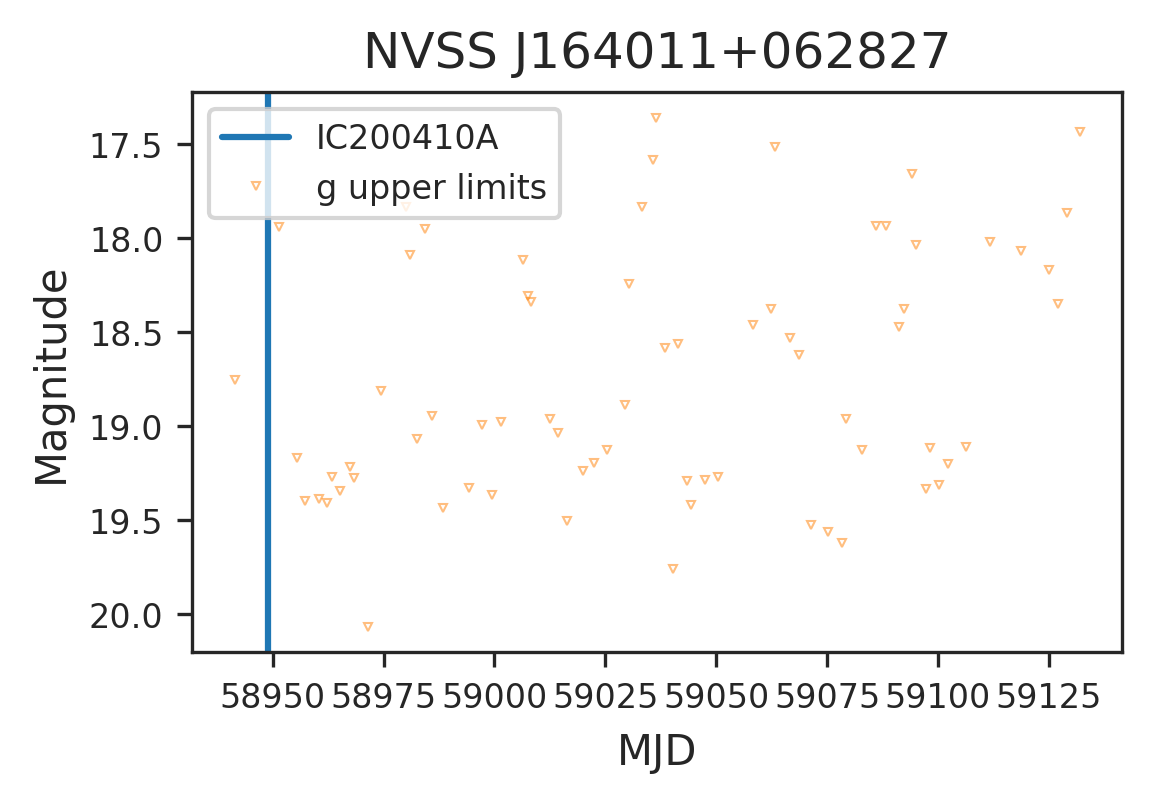

In [69]:
r = fermi_matches.iloc[92]
fig, ax, mjd = plot_lc(r, unit='mag', timerange=[-10, 200])
#fig.tight_layout()
plt.show()
plt.close()

In [7]:
r.Counterpart.strip(' ')

'NVSS J164011+062827'

In [70]:
for i, r in fermi_matches.iterrows():
    fgl_name = r['4FGL Name']
    fn = [ifn for ifn in os.listdir(fermi_lightcurves_dir) if ifn.startswith(fgl_name.replace(' ', '_')) and ifn.endswith('.dat')]
    print(fgl_name, len(fn), fn)
    
    fig, ax, nmjd = plot_lc(r)
    fn = os.path.join(fermi_lightcurves_plot_dir, f"{r.name[0]}_{r['4FGL Name'].replace(' ', '_')}.pdf")
    print(f"saving under {fn}")
    #fig.tight_layout()
    fig.subplots_adjust(bottom=0.2)
    fig.subplots_adjust(left=0.15)
    fig.savefig(fn)
    
    ax.set_xlim([nmjd-100, nmjd+100])
    fn = os.path.join(fermi_lightcurves_plot_dir, f"{r.name[0]}_{r['4FGL Name'].replace(' ', '_')}_closeup.pdf")
    print(f"saving under {fn}")
#     fig.tight_layout()
    fig.savefig(fn)
    plt.close()

4FGL J0244.7+1316  2 ['4FGL_J0244.7+1316_g.dat', '4FGL_J0244.7+1316_V.dat']
saving under ../figures/fermi_lightcurves/IC161103A_4FGL_J0244.7+1316_.pdf
saving under ../figures/fermi_lightcurves/IC161103A_4FGL_J0244.7+1316__closeup.pdf
4FGL J0509.4+0542  2 ['4FGL_J0509.4+0542_g.dat', '4FGL_J0509.4+0542_V.dat']
saving under ../figures/fermi_lightcurves/IC170922A_4FGL_J0509.4+0542_.pdf
saving under ../figures/fermi_lightcurves/IC170922A_4FGL_J0509.4+0542__closeup.pdf
4FGL J1457.4-3539  2 ['4FGL_J1457.4-3539_g.dat', '4FGL_J1457.4-3539_V.dat']
saving under ../figures/fermi_lightcurves/IC181014A_4FGL_J1457.4-3539_.pdf
saving under ../figures/fermi_lightcurves/IC181014A_4FGL_J1457.4-3539__closeup.pdf
4FGL J1505.0-3433  2 ['4FGL_J1505.0-3433_g.dat', '4FGL_J1505.0-3433_V.dat']
saving under ../figures/fermi_lightcurves/IC181014A_4FGL_J1505.0-3433_.pdf
saving under ../figures/fermi_lightcurves/IC181014A_4FGL_J1505.0-3433__closeup.pdf
4FGL J1804.4-0852  2 ['4FGL_J1804.4-0852_g.dat', '4FGL_J1804.4-0

In [71]:
for i, r in fermi_matches.iterrows():
    fgl_name = r['4FGL Name']
    fn = [ifn for ifn in os.listdir(fermi_lightcurves_dir) if ifn.startswith(fgl_name.replace(' ', '_')) and ifn.endswith('.dat')]
    print(fgl_name, len(fn), fn)
    
    fig, ax, nmjd = plot_lc(r, unit='mag')
    fn = os.path.join(fermi_lightcurves_plot_dir, f"{r.name[0]}_{r['4FGL Name'].replace(' ', '_')}mag.pdf")
    print(f"saving under {fn}")
    #fig.tight_layout()
    fig.subplots_adjust(bottom=0.2)
    fig.subplots_adjust(left=0.15)
    fig.savefig(fn)
    plt.close()
    
    fig, ax, nmjd = plot_lc(r, unit='mag', timerange=[-100, 100])
#     ax.set_xlim([nmjd-100, nmjd+100])
    fn = os.path.join(fermi_lightcurves_plot_dir, f"{r.name[0]}_{r['4FGL Name'].replace(' ', '_')}mag_closeup.pdf")
    fig.subplots_adjust(bottom=0.2)
    fig.subplots_adjust(left=0.15)
    print(f"saving under {fn}")
#     fig.tight_layout()
    fig.savefig(fn)
    plt.close()

4FGL J0244.7+1316  2 ['4FGL_J0244.7+1316_g.dat', '4FGL_J0244.7+1316_V.dat']
saving under ../figures/fermi_lightcurves/IC161103A_4FGL_J0244.7+1316_mag.pdf
saving under ../figures/fermi_lightcurves/IC161103A_4FGL_J0244.7+1316_mag_closeup.pdf
4FGL J0509.4+0542  2 ['4FGL_J0509.4+0542_g.dat', '4FGL_J0509.4+0542_V.dat']
saving under ../figures/fermi_lightcurves/IC170922A_4FGL_J0509.4+0542_mag.pdf
saving under ../figures/fermi_lightcurves/IC170922A_4FGL_J0509.4+0542_mag_closeup.pdf
4FGL J1457.4-3539  2 ['4FGL_J1457.4-3539_g.dat', '4FGL_J1457.4-3539_V.dat']
saving under ../figures/fermi_lightcurves/IC181014A_4FGL_J1457.4-3539_mag.pdf
saving under ../figures/fermi_lightcurves/IC181014A_4FGL_J1457.4-3539_mag_closeup.pdf
4FGL J1505.0-3433  2 ['4FGL_J1505.0-3433_g.dat', '4FGL_J1505.0-3433_V.dat']
saving under ../figures/fermi_lightcurves/IC181014A_4FGL_J1505.0-3433_mag.pdf
saving under ../figures/fermi_lightcurves/IC181014A_4FGL_J1505.0-3433_mag_closeup.pdf
4FGL J1804.4-0852  2 ['4FGL_J1804.4-0852

In [ ]:
interesting = ['4FGL J1555.7+1111 ', '4FGL J2211.0-0003 ', '4FGL J0312.9+3614 ']


for fgl_name in interesting:
    
    r = fermi_matches.loc[fermi_matches['4FGL Name'] == fgl_name].iloc[0]
    fig, ax, nmjd = plot_lc(r, unit='mag')
    ax.set_xlim([nmjd-100, nmjd+400])
    plt.show()
    plt.close()

saving under ../figures/fermi_lightcurves/IC190730A_4FGL_J1504.4+1029_mag_closeup.pdf


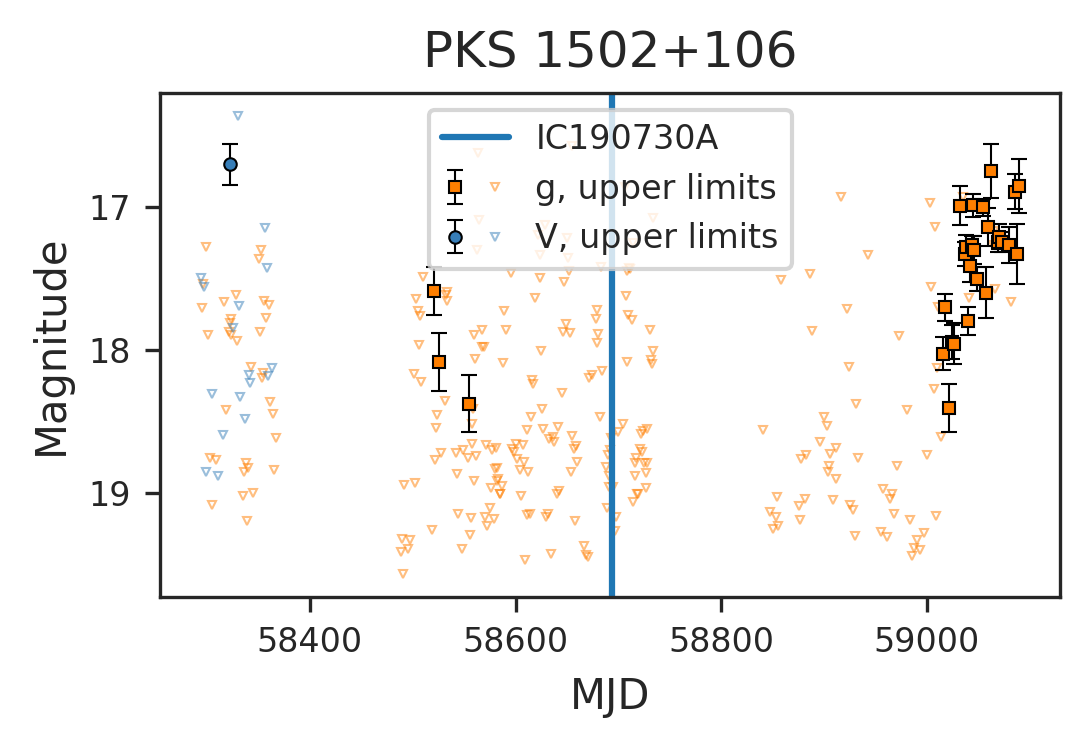

In [72]:
interesting = ['4FGL J1504.4+1029 ']


for fgl_name in interesting:
    
    r = fermi_matches.loc[fermi_matches['4FGL Name'] == fgl_name].iloc[0]
    fig, ax, nmjd = plot_lc(r, unit='mag', timerange=[-400, 400])
    fn = os.path.join(fermi_lightcurves_plot_dir, f"{r.name[0]}_{r['4FGL Name'].replace(' ', '_')}mag_closeup.pdf")
    fig.subplots_adjust(bottom=0.2)
    fig.subplots_adjust(left=0.15)
    print(f"saving under {fn}")
    ax.set_xticks([58400, 58600, 58800, 59000])
#     fig.tight_layout()
    fig.savefig(fn)
#    plt.show()
#    plt.close()

In [78]:
r

,,,3FHL Name,4FGL Name,Fermi ra,Fermi dec,Counterpart,Counterpart ra,Counterpart dec,Counterpart prob,ra,dec
Event,Fermi Cat,Macth ind,,,,,,,,,,
IC200410A,4FGL,18,3FHL J1555.7+1111,4FGL J1555.7+1111,238.9313,11.1884,PG 1553+113,238.92935,11.190102,0.998565,238.92935,11.190102


In [75]:
fermi_matches.loc['IC200410A'].iloc[18]

3FHL Name                     3FHL J1555.7+1111 
4FGL Name                     4FGL J1555.7+1111 
Fermi ra                                238.9313
Fermi dec                                11.1884
Counterpart         PG 1553+113                 
Counterpart ra                         238.92935
Counterpart dec                        11.190102
Counterpart prob                        0.998565
ra                                     238.92935
dec                                    11.190102
Name: (4FGL, 18), dtype: object

In [76]:
np.any(fermi_matches['4FGL Name'] == '4FGL J1555.7+1111 ')

True